<a href="https://colab.research.google.com/github/LauriNieminen/LauriNieminen.github.io/blob/master/CS_E4875_course_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Demo Notebook for Hyperspectral Super-Resolution Model (CS-E4875-course)

### import Libraries

In [1]:
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from skimage.metrics import structural_similarity as ssim

### Preprocessing the dataset

Keys in loaded .mat file: dict_keys(['__header__', '__version__', '__globals__', 'paviaU'])
Hyperspectral image shape: (610, 340, 103)
X_train_hr shape: (44, 144, 144, 16)
X_validation_hr shape: (6, 144, 144, 16)
X_test_hr shape: (14, 144, 144, 16)
X_train_lr shape: (44, 18, 18, 16)
X_validation_lr shape: (6, 18, 18, 16)
X_test_lr shape: (14, 18, 18, 16)
Training Sample:


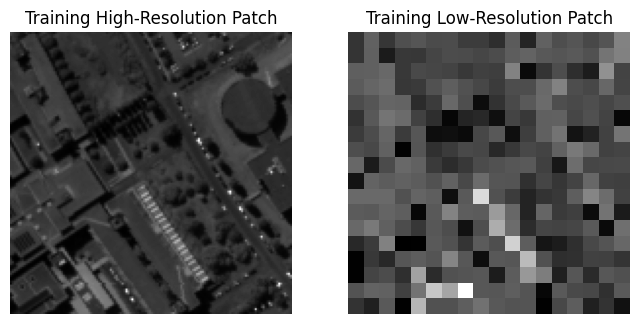

Validation Sample:


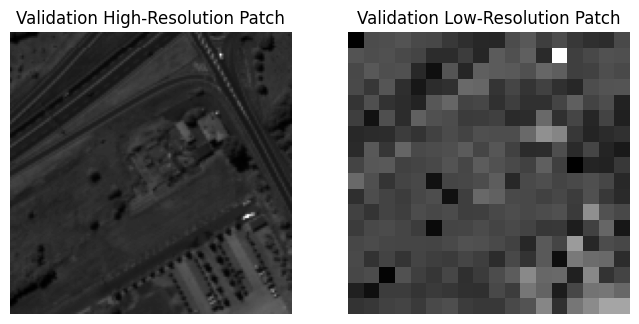

Test Sample:


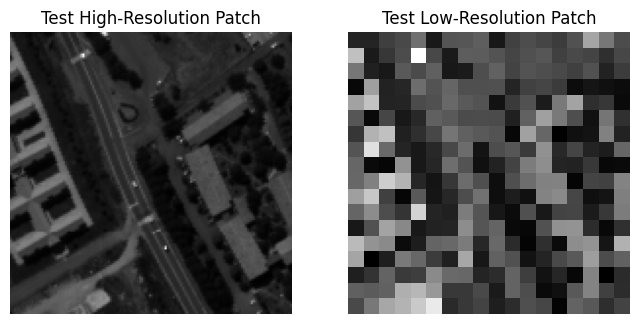

In [2]:

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the Pavia dataset
try:
    data = loadmat("PaviaU.mat")  # Ensure that the file path is correct
except Exception as e:
    raise ValueError(f"Error loading .mat file: {e}")

# Access the hyperspectral image using the correct key 'paviaU'
print("Keys in loaded .mat file:", data.keys())
if 'paviaU' in data:
    hyperspectral_image = data['paviaU']
else:
    raise KeyError("'paviaU' not found in the .mat file.")

# Check the shape of the hyperspectral image
print("Hyperspectral image shape:", hyperspectral_image.shape)

# Convert to float32 for TensorFlow operations
hyperspectral_image = hyperspectral_image.astype(np.float32)

# Parameters
patch_size = (144, 144)  # Size of patches to extract
test_size = 0.2  # Proportion of data for testing
validation_size = 0.1  # Proportion of data for validation
downscale_factor = 8  # Factor to downscale patches
nodata_value = -1  # Value that indicates "no data"
group_size = 16  # Group size for spectral bands
overlap_size = 4  # Overlap size for grouped bands

# Function to group bands into overlapping subgroups
def group_bands_with_overlap(data, group_size=6, overlap_size=2):
    height, width, bands = data.shape
    step_size = group_size - overlap_size  # Calculate step size based on overlap
    grouped_data = []

    # Create overlapping groups of bands
    for g in range(0, bands - group_size + 1, step_size):
        group = data[:, :, g:g + group_size]
        grouped_data.append(group)

    return np.array(grouped_data)

# Extract and downscale patches from hyperspectral data
def extract_and_downscale_patches(data, patch_size, downscale_factor, nodata_value=0):
    patches_hr = []
    patches_lr = []
    height, width, bands = data.shape

    for i in range(0, height - patch_size[0] + 1, patch_size[0]):
        for j in range(0, width - patch_size[1] + 1, patch_size[1]):
            patch_hr = data[i:i + patch_size[0], j:j + patch_size[1], :]

            # Check for nodata_value and skip patch extraction if present
            if np.any(patch_hr == nodata_value):
                continue

            patch_lr = tf.image.resize(patch_hr,
                                        [patch_size[0] // downscale_factor, patch_size[1] // downscale_factor],
                                        method='bilinear')
            patches_hr.append(patch_hr)
            patches_lr.append(patch_lr.numpy())  # Convert tensor to numpy

    return np.array(patches_hr), np.array(patches_lr)

# Group bands into overlapping subgroups
grouped_data = group_bands_with_overlap(hyperspectral_image, group_size=group_size, overlap_size=overlap_size)

# Extract and downscale patches for all groups
all_patches_hr = []
all_patches_lr = []

for group in grouped_data:
    patches_hr, patches_lr = extract_and_downscale_patches(group, patch_size, downscale_factor, nodata_value=nodata_value)
    all_patches_hr.append(patches_hr)
    all_patches_lr.append(patches_lr)

# Concatenate patches from all groups
all_patches_hr = np.concatenate(all_patches_hr, axis=0)
all_patches_lr = np.concatenate(all_patches_lr, axis=0)

# Calculate the number of patches
num_patches = len(all_patches_hr)

# Calculate sizes for training, validation, and testing sets
train_size = int((1 - test_size - validation_size) * num_patches)
validation_size = int(validation_size * num_patches)
test_size = num_patches - (train_size + validation_size)  # Explicit calculation of test size

# Shuffle indices for splitting the data
indices = np.arange(num_patches)
np.random.shuffle(indices)
all_patches_hr = all_patches_hr[indices]
all_patches_lr = all_patches_lr[indices]

# Split into training, validation, and testing sets
X_train_hr, X_validation_hr, X_test_hr = np.split(all_patches_hr, [train_size, train_size + validation_size])
X_train_lr, X_validation_lr, X_test_lr = np.split(all_patches_lr, [train_size, train_size + validation_size])

# Print shapes to verify
print("X_train_hr shape:", X_train_hr.shape)
print("X_validation_hr shape:", X_validation_hr.shape)
print("X_test_hr shape:", X_test_hr.shape)

print("X_train_lr shape:", X_train_lr.shape)
print("X_validation_lr shape:", X_validation_lr.shape)
print("X_test_lr shape:", X_test_lr.shape)

# Function to plot a high-resolution and low-resolution patch side by side
def plot_sample(hr_patch, lr_patch, title):
    plt.figure(figsize=(8, 4))

    # Plot high-resolution patch
    plt.subplot(1, 2, 1)
    plt.imshow(hr_patch[:, :, 0], cmap='gray')  # Displaying the first spectral band
    plt.title(f"{title} High-Resolution Patch")
    plt.axis('off')

    # Plot low-resolution patch
    plt.subplot(1, 2, 2)
    plt.imshow(lr_patch[:, :, 0], cmap='gray')  # Displaying the first spectral band
    plt.title(f"{title} Low-Resolution Patch")
    plt.axis('off')

    plt.show()

# Display one training, validation, and test sample
print("Training Sample:")
plot_sample(X_train_hr[0], X_train_lr[0], "Training")

print("Validation Sample:")
plot_sample(X_validation_hr[0], X_validation_lr[0], "Validation")

print("Test Sample:")
plot_sample(X_test_hr[0], X_test_lr[0], "Test")


## Insert the Model of your choice

In [3]:

# Simple Convolutional Block
def conv_block(x, filters, kernel_size=(3, 3)):
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Upsampling Block
def upsample_block(x, filters, scale=2):
    x = UpSampling2D(size=(scale, scale), interpolation='bilinear')(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# Build Simple CNN Model for Hyperspectral Super-Resolution
def build_simple_cnn_sr_model(input_shape):
    inputs = Input(shape=input_shape)

    # Feature extraction layers
    x = conv_block(inputs, filters=32)
    x = conv_block(x, filters=64)
    x = conv_block(x, filters=128)

    # Upsampling layers
    x = upsample_block(x, filters=64, scale=2)   # 2x upscaling
    x = upsample_block(x, filters=32, scale=2)   # If you want upscale 4x upscaling then uncomment, if not then comment it
    x = upsample_block(x, filters=32, scale=2)   # If you want upscale 8x upscaling, if not then comment it

    # Output layer with the original number of channels
    x_out = Conv2D(input_shape[-1], (3, 3), padding='same')(x)
    x_out = Activation('linear')(x_out)

    # Define the model
    model = Model(inputs=inputs, outputs=x_out, name="Simple_CNN_SR_Model")
    return model

# Define input shape for hyperspectral data
input_shape = (18, 18, 16)  # Example input shape for low-resolution hyperspectral patch

# Build the model
simple_cnn_sr_model = build_simple_cnn_sr_model(input_shape)

# Compile the model
simple_cnn_sr_model.compile(optimizer='adam', loss='mse')

# Display model summary
simple_cnn_sr_model.summary()


Model: "Simple_CNN_SR_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 18, 18, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 18, 18, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 18, 18, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 18, 18, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 18, 18, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 18, 18, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 18, 18, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 18, 18, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 36, 36, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 36, 36, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 36, 36, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 72, 72, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 72, 72, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 72, 72, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 144, 144, 32)        │              

 Total params: 204,528 (798.94 KB)

 Trainable params: 203,824 (796.19 KB)

 Non-trainable params: 704 (2.75 KB)

## Train the model

In [ ]:
### # Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Train the model and get the training history with early stopping
history = simple_cnn_sr_model.fit(
    X_train_lr,
    X_train_hr,
    epochs=500,
    batch_size=4,
    validation_data=(X_validation_lr, X_validation_hr),
    callbacks=[early_stopping]  # Add the early stopping callback here
)

# Visualize training and validation loss over epochs
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Add grid for better readability
plt.show()

Epoch 1/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 632ms/step - loss: 2760673.5000 - val_loss: 2651213.2500
Epoch 2/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 449ms/step - loss: 2754430.7500 - val_loss: 2508082.5000
Epoch 3/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 595ms/step - loss: 2747766.7500 - val_loss: 2468202.7500
Epoch 4/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 471ms/step - loss: 2740048.0000 - val_loss: 2441586.0000
Epoch 5/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 441ms/step - loss: 2730807.5000 - val_loss: 2478078.2500
Epoch 6/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 589ms/step - loss: 2721374.7500 - val_loss: 2502083.7500
Epoch 7/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 477ms/step - loss: 2711490.5000 - val_loss: 2502511.2500
Epoch 8/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 443ms/step - loss: 2701193.5000 - val_loss: 2525451.7500
Epoch 9/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 585ms/step - loss: 2690469.7500 - val_loss: 2536069.2500
Epoch 10/500
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 484ms/step - loss: 2679303.5000 - val_loss: 2490661.7500
Epoch 

## Report all the metrices such as PSNR, SSIM, SAM, ERGAS etc.,

In [ ]:

# Function to calculate PSNR without normalization
def psnr(y_true, y_pred):
    max_pixel = np.max(y_true)  # Use the actual max value from y_true
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:  # Avoid log of zero
        return float('inf')
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")

    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])

    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)

    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))

    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0

    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")

    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]

        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)

        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band

        ergas_value += (rmse_band / mean_band_true) ** 2

    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images = simple_cnn_sr_model.predict(X_test_lr)
downscale_factor = 2 # ERGAS downscale factor

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    ergas_values.append(ergas(X_test_hr[i], predicted_hr_images[i], downscale_factor))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average ERGAS on the test set:", average_ergas)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized


1/1 [==============================] - 1s 522ms/step
Average PSNR on the test set: 30.221104962485178
Average SSIM on the test set: 0.9100986
Average SAM on the test set (in degrees): 4.692667778387005
Average Correlation Coefficient on the test set: 0.945538293669639
Average ERGAS on the test set: 9.15514410078758
Average RMSE: 0.031690743


## Scale size 4

In [ ]:

# Function to calculate PSNR without normalization
def psnr(y_true, y_pred):
    max_pixel = np.max(y_true)  # Use the actual max value from y_true
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:  # Avoid log of zero
        return float('inf')
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")

    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])

    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)

    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))

    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0

    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")

    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]

        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)

        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band

        ergas_value += (rmse_band / mean_band_true) ** 2

    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images = simple_cnn_sr_model.predict(X_test_lr)
downscale_factor = 4 # ERGAS downscale factor

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    ergas_values.append(ergas(X_test_hr[i], predicted_hr_images[i], downscale_factor))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average ERGAS on the test set:", average_ergas)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized


1/1 [==============================] - 0s 411ms/step
Average PSNR on the test set: 27.6015841960907
Average SSIM on the test set: 0.80812085
Average SAM on the test set (in degrees): 4.696001886443281
Average Correlation Coefficient on the test set: 0.9069213991165244
Average ERGAS on the test set: 6.148700758030372
Average RMSE: 0.04290982


## Scale size 8

In [ ]:

# Function to calculate PSNR without normalization
def psnr(y_true, y_pred):
    max_pixel = np.max(y_true)  # Use the actual max value from y_true
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:  # Avoid log of zero
        return float('inf')
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")

    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])

    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)

    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))

    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0

    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")

    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]

        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)

        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band

        ergas_value += (rmse_band / mean_band_true) ** 2

    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images = simple_cnn_sr_model.predict(X_test_lr)
downscale_factor = 8 # ERGAS downscale factor

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    ergas_values.append(ergas(X_test_hr[i], predicted_hr_images[i], downscale_factor))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average ERGAS on the test set:", average_ergas)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized


1/1 [==============================] - 0s 370ms/step
Average PSNR on the test set: 26.855959381375992
Average SSIM on the test set: 0.76512194
Average SAM on the test set (in degrees): 4.698979681215868
Average Correlation Coefficient on the test set: 0.8871284486519996
Average ERGAS on the test set: 3.3437867006214357
Average RMSE: 0.047208507


In [ ]:

# Function to calculate PSNR without normalization
def psnr(y_true, y_pred):
    max_pixel = np.max(y_true)  # Use the actual max value from y_true
    mse = np.mean((y_true - y_pred) ** 2)
    if mse == 0:  # Avoid log of zero
        return float('inf')
    psnr_value = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr_value

# Function to calculate SSIM with channel_axis
def ssim_value(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true shape {y_true.shape} vs y_pred shape {y_pred.shape}")

    data_range = y_true.max() - y_true.min()  # Calculate data range from y_true
    ssim_val = ssim(y_true, y_pred, data_range=data_range, channel_axis=-1)
    return ssim_val

# Function to calculate Correlation Coefficient
def correlation_coefficient(y_true, y_pred):
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    corr_matrix = np.corrcoef(y_true_flat, y_pred_flat)
    corr_value = corr_matrix[0, 1]
    return corr_value

# Function to calculate Spectral Angle Mapper (SAM) in degrees
def sam(y_true, y_pred):
    y_true_reshaped = y_true.reshape(-1, y_true.shape[-1])
    y_pred_reshaped = y_pred.reshape(-1, y_pred.shape[-1])

    non_zero_mask = (np.linalg.norm(y_true_reshaped, axis=1) > 1e-10) & (np.linalg.norm(y_pred_reshaped, axis=1) > 1e-10)
    dot_product = np.sum(y_true_reshaped[non_zero_mask] * y_pred_reshaped[non_zero_mask], axis=1)
    norm_true = np.linalg.norm(y_true_reshaped[non_zero_mask], axis=1)
    norm_pred = np.linalg.norm(y_pred_reshaped[non_zero_mask], axis=1)

    with np.errstate(divide='ignore', invalid='ignore'):
        angles = np.arccos(np.clip(dot_product / (norm_true * norm_pred), -1.0, 1.0))

    if angles.size > 0:
        sam_value_degrees = np.mean(angles) * (180 / np.pi)
    else:
        sam_value_degrees = 0

    return sam_value_degrees

# Function to normalize the images
def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val)  # Normalize to [0, 1]

# Function to calculate Root Mean Squared Error (RMSE) for hyperspectral images (normalized)
def rmse_bandwise(y_true, y_pred):
    if y_true.shape != y_pred.shape:
        raise ValueError("Shape mismatch between true and predicted images.")

    bands = y_true.shape[-1]
    rmse_per_band = []

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]

        mse_band = np.mean((band_true - band_pred) ** 2)
        rmse_band_value = np.sqrt(mse_band)
        rmse_per_band.append(rmse_band_value)

    # Normalize RMSE by the maximum value in y_true across all bands
    max_value = np.max(y_true)
    normalized_rmse = np.mean(rmse_per_band) / max_value
    return normalized_rmse

# Function to calculate ERGAS
def ergas(y_true, y_pred, scale):
    bands = y_true.shape[-1]
    ergas_value = 0

    for b in range(bands):
        band_true = y_true[:, :, b]
        band_pred = y_pred[:, :, b]
        mean_band_true = np.mean(band_true)

        # Calculate RMSE for the band without using a separate function
        mse_band = np.mean((band_true - band_pred) ** 2)  # Mean Squared Error for the band
        rmse_band = np.sqrt(mse_band)  # Root Mean Squared Error for the band

        ergas_value += (rmse_band / mean_band_true) ** 2

    ergas_value = 100 * (1 / scale) * np.sqrt(ergas_value / bands)
    return ergas_value

# Assuming hybrid_sr_model is trained, and X_test_lr, X_test_hr are defined
predicted_hr_images = residual_cnn_sr_model.predict(X_test_lr)
downscale_factor = 8 # ERGAS downscale factor

# Validate shapes match for test and predictions
if predicted_hr_images.shape != X_test_hr.shape:
    raise ValueError(f"Shape mismatch: predicted_hr_images shape {predicted_hr_images.shape} vs X_test_hr shape {X_test_hr.shape}")

# Calculate metrics per test sample
psnr_values, ssim_values, cc_values, sam_values, ergas_values, rmse_values = [], [], [], [], [], []

for i in range(len(X_test_hr)):
    psnr_values.append(psnr(X_test_hr[i], predicted_hr_images[i]))
    ssim_values.append(ssim_value(X_test_hr[i], predicted_hr_images[i]))
    cc_values.append(correlation_coefficient(X_test_hr[i], predicted_hr_images[i]))
    sam_values.append(sam(X_test_hr[i], predicted_hr_images[i]))
    ergas_values.append(ergas(X_test_hr[i], predicted_hr_images[i], downscale_factor))
    rmse_values.append(rmse_bandwise(X_test_hr[i], predicted_hr_images[i]))

# Average metrics
average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_cc = np.mean(cc_values)
average_sam = np.mean(sam_values)
average_ergas = np.mean(ergas_values)
average_rmse = np.mean(rmse_values)

# Print the evaluation metrics
print("Average PSNR on the test set:", average_psnr)
print("Average SSIM on the test set:", average_ssim)
print("Average SAM on the test set (in degrees):", average_sam)
print("Average Correlation Coefficient on the test set:", average_cc)
print("Average ERGAS on the test set:", average_ergas)
print("Average RMSE:", average_rmse)  # Indicate RMSE is normalized


1/1 [==============================] - 0s 450ms/step
Average PSNR on the test set: 23.274510077067784
Average SSIM on the test set: 0.53754276
Average SAM on the test set (in degrees): 3.639469622860131
Average Correlation Coefficient on the test set: 0.7245856279859101
Average ERGAS on the test set: 5.066461490640917
Average RMSE: 0.0710594
